
# Template — MVP: *Machine Learning & Analytics*
**Autor:** Gabriel Pugliese Salgado  

**Data:** 28/09/2025

**Matrícula:** 4052025001039

**Dataset:** Inadimplência_quantitativa_2
---



## 1. Escopo, objetivo e definição do problema
O presente projeto tem como objetivo **prever a inadimplência de clientes** a partir de informações financeiras e comportamentais, como atrasos em pagamentos, tempo de relacionamento, renda mensal e gastos. Trata-se de um problema de **classificação supervisionada**, em que o modelo deve distinguir entre clientes **adimplentes (classe 0)** e **inadimplentes (classe 1)**.

A aplicação está inserida no contexto de **dados tabulares** do setor financeiro, utilizando variáveis quantitativas (ex.: renda, valor da fatura) e categóricas (ex.: nível de risco cadastral).

O valor para o negócio consiste em **reduzir perdas financeiras e apoiar a gestão de risco de crédito**. Ao identificar previamente clientes com maior probabilidade de inadimplir, a instituição pode:

*   ajustar limites de crédito,
*   aplicar políticas diferenciadas de cobrança,
*   precificar melhor produtos financeiros,
*   aumentar a rentabilidade com menor exposição ao risco.

Assim, o projeto agrega valor estratégico para a empresa ao equilibrar **mitigação de riscos e oportunidades de receita** no mercado de crédito.


## 2. Reprodutibilidade e ambiente

Principais bibliotecas utilizadas:

* **pandas** e **numpy** – manipulação e análise de dados.

* **scikit-learn** – construção dos pipelines de pré-processamento, treino e avaliação dos modelos.

* **matplotlib** – visualização de métricas e curvas ROC.


Reprodutibilidade:

Todas as etapas que envolvem aleatoriedade (como **train_test_split**, validação cruzada e inicialização de modelos) foram configuradas com **seeds fixas** (random_state=42).

Isso garante que os resultados (divisão entre treino e teste, desempenho dos modelos e métricas) possam ser **reproduzidos em execuções futuras** no mesmo ambiente.

In [65]:
# === Setup básico e reprodutibilidade ===
import random
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import joblib
from pathlib import Path


from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report, ConfusionMatrixDisplay
)
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from scipy.stats import randint, uniform

# Fixar seed para reprodutibilidade
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

print("Python:", sys.version.split()[0])
print("Seed global:", SEED)


Python: 3.12.11
Seed global: 42



## 3. Dados: carga, entendimento e qualidade
O dataset Inadimplencia_quantitativa_2.csv contém informações financeiras e cadastrais de clientes, incluindo histórico de pagamentos, tempo de relacionamento e renda mensal. Esses dados simulam um cenário de crédito, com a variável alvo Resposta indicando se o cliente foi **adimplente (0)** ou **inadimplente (1)**.


### Atributos do Dataset
O dataset contém as seguintes variáveis:

* **cliente**: Identificador único do cliente.

* **Resposta**: Variável alvo (0 = adimplente, 1 = inadimplente).

* **RegRisc**: Região de risco do cliente (categorias: I, II, III, IV).

* **Atrasos**: Número de dias de atraso nos pagamentos.

* **TempoRel**: Tempo de relacionamento com a instituição (em dias).

* **valorFatura**: Valor médio da fatura mensal.

* **GastosAlim**: Percentual dos gastos do cliente com alimentação.

* **RendaMensal**: Renda mensal do cliente.

### Qualidade e ética:

* Foram aplicados tratamentos básicos de **valores ausentes** (mediana para numéricos e moda para categóricos).

* Não há informações pessoais sensíveis (como CPF ou dados de identificação direta).

* Como o dataset é simulado/quantitativo, não envolve risco ético ou restrição de licença de uso.

### Cuidados contra vazamento de dados:

* A variável alvo não foi utilizada em nenhuma etapa do pré-processamento.

* O split entre treino e teste foi realizado de forma estratificada antes de qualquer transformação.

* Apenas variáveis disponíveis **antes do evento de inadimplência** foram consideradas como preditores.


In [66]:

# Carregar dataset real de inadimplência
url = 'https://raw.githubusercontent.com/gabrielpugliese/projeto-inadimplencia2/refs/heads/main/Inadimplencia_quantitativa_2.csv'
df = pd.read_csv(url,sep=';')

# Exibir primeiras linhas
df.head()


,cliente,Resposta,RegRisc,Atrasos,TempoRel,valorFatura,GastosAlim,RendaMensal
0,2,0,III,2,5148,62,4,4364
1,6,0,I,7,5030,163,17,4351
2,8,1,II,12,235,250,16,1375
3,9,1,I,37,300,381,64,1777
4,13,0,I,7,223,8055,10,3909


In [67]:

# === Verificações iniciais ===
display(df.sample(5))
print("\nFormato:", df.shape)
print("\nTipos:")
print(df.dtypes)
print("\nValores ausentes por coluna:")
print(df.isna().sum())


,cliente,Resposta,RegRisc,Atrasos,TempoRel,valorFatura,GastosAlim,RendaMensal
107,268,1,I,23,334,600,12,19033
5474,12824,0,IV,12,980,619,41,5920
7690,18132,1,I,29,361,671,16,11678
6326,14905,0,II,3,759,197,75,28126
2337,5511,0,IV,1,328,86,5,2409



Formato: (10986, 8)

Tipos:
cliente         int64
Resposta        int64
RegRisc        object
Atrasos         int64
TempoRel        int64
valorFatura     int64
GastosAlim      int64
RendaMensal     int64
dtype: object

Valores ausentes por coluna:
cliente        0
Resposta       0
RegRisc        0
Atrasos        0
TempoRel       0
valorFatura    0
GastosAlim     0
RendaMensal    0
dtype: int64



### 3.1 Análise exploratória resumida (EDA)
Como este mesmo dataset já havia sido utilizado no primeiro **MVP de Análise de Dados e Boas Práticas**, aqui a EDA é apresentada de forma **reduzida**, apenas para garantir consistência metodológica dentro do fluxo de Machine Learning.

Já se sabe, a partir da análise anterior, que existem **outliers relevantes** em valorFatura, com valores extremamente altos que distorcem a distribuição. Esses outliers foram tratados nesta etapa para permitir melhor treinamento dos modelos.

Além disso, por se tratar de uma variável categórica, a coluna **RegRisc** foi transformada em variáveis **dummies** (dummy encoding), possibilitando que os algoritmos de classificação utilizem essas informações de forma adequada.


/tmp/ipython-input-1116007916.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Resposta', data=df, palette='Blues')


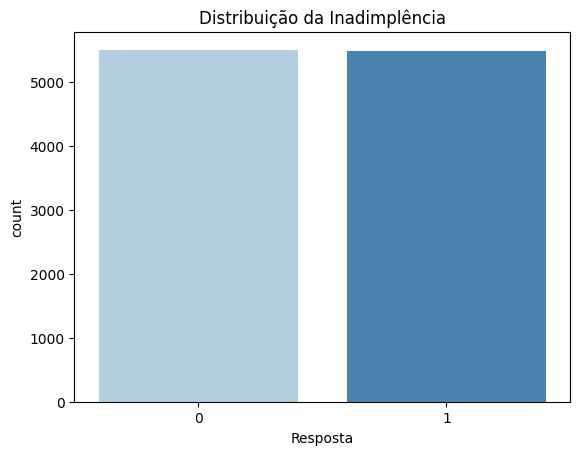

,cliente,%
Resposta,,
0,5503,50.09
1,5483,49.91


In [68]:
# Distribuição da variável alvo
sns.countplot(x='Resposta', data=df, palette='Blues')
plt.title('Distribuição da Inadimplência')
plt.show()
# Verificando a tabela de frequência da variável Resposta do modelo
Resposta =pd.pivot_table(df, index='Resposta', values='cliente', aggfunc=np.count_nonzero)
Resposta['%'] = ((pd.pivot_table(df, index='Resposta', values = 'cliente', aggfunc=np.count_nonzero)/df['cliente'].count())*100).round(2)

Resposta

Com apenas o gráfico de distribuição, é possível perceber que o dataset está bem balanceado em termos de clientes adimplentes (Resposta = 0) e inadimplentes (Resposta = 1). A tabela de frequência da variável Resposta mostra que 50,09% dos registros correspondem a clientes adimplentes, enquanto 49,91% são inadimplentes.

In [69]:
# Estatísticas descritivas gerais
display(df.describe())


,cliente,Resposta,Atrasos,TempoRel,valorFatura,GastosAlim,RendaMensal
count,10986.000000,10986.000000,10986.000000,10986.000000,10986.000000,10986.000000,10986.000000
mean,12947.128982,0.499090,19.687147,1796.758147,1400.987348,27.069634,6053.556800
std,7508.724663,0.500022,17.716952,1610.791743,2405.437586,22.992852,7434.910169
min,2.000000,0.000000,0.000000,180.000000,45.000000,0.000000,750.000000
25%,6499.000000,0.000000,4.000000,337.000000,207.000000,10.000000,1515.000000
50%,12884.500000,0.000000,15.000000,1144.500000,560.500000,22.000000,2991.000000
75%,19477.500000,1.000000,29.000000,2975.000000,1198.750000,31.000000,4527.250000
max,25984.000000,1.000000,65.000000,5475.000000,100000.000000,90.000000,29986.000000


/tmp/ipython-input-3990654804.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Resposta', y='valorFatura', data=df, palette='hls')


<Axes: xlabel='Resposta', ylabel='valorFatura'>

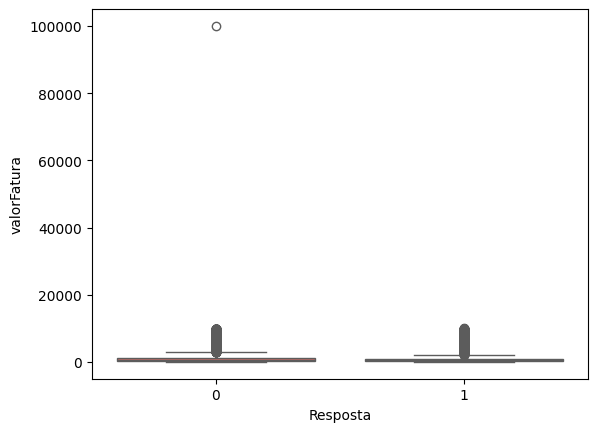

In [70]:
# Atributo Valor da Fatura:

sns.boxplot(x='Resposta', y='valorFatura', data=df, palette='hls')


O gráfico acima comprovou a hipótese de existência de outliers discrepantes. Para eliminá-los, vamos "achatar" o seu valor

/tmp/ipython-input-905517065.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Resposta', y='valorFatura', data=df, palette='hls')


<Axes: xlabel='Resposta', ylabel='valorFatura'>

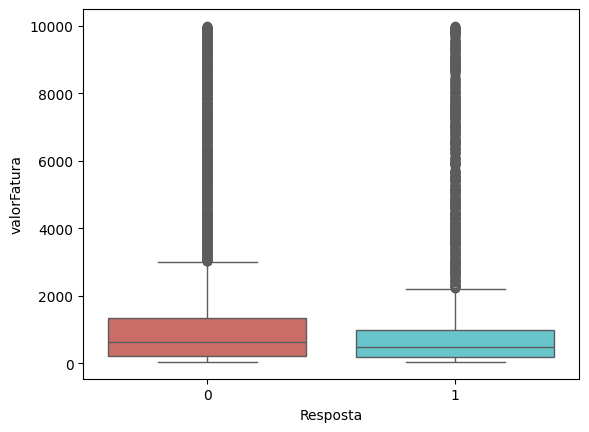

In [71]:
# Achatando os outliers discrepantes
df.loc[df['valorFatura']>=50000, 'valorFatura'] = 10000

sns.boxplot(x='Resposta', y='valorFatura', data=df, palette='hls')

/tmp/ipython-input-2561394440.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Resposta', y=col, data=df, palette='Blues')


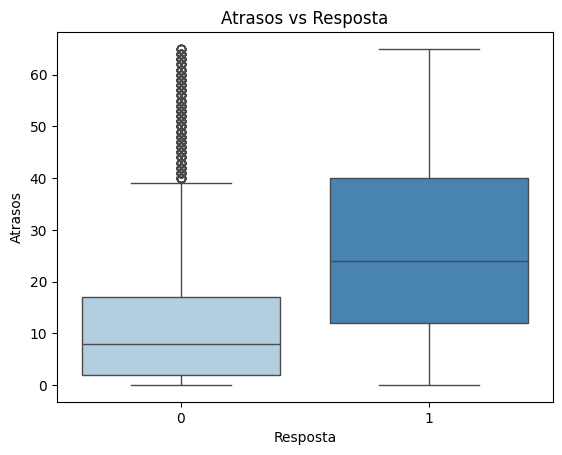

/tmp/ipython-input-2561394440.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Resposta', y=col, data=df, palette='Blues')


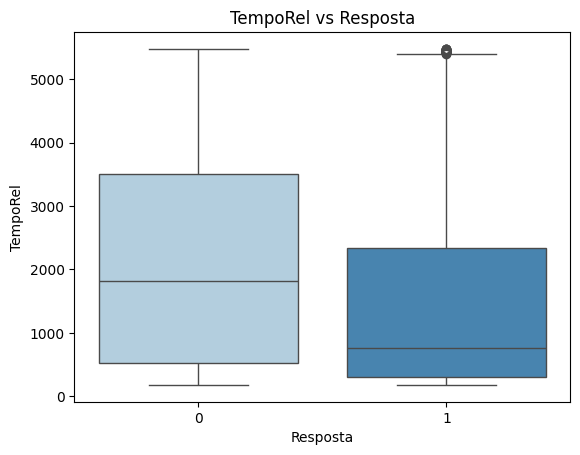

/tmp/ipython-input-2561394440.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Resposta', y=col, data=df, palette='Blues')


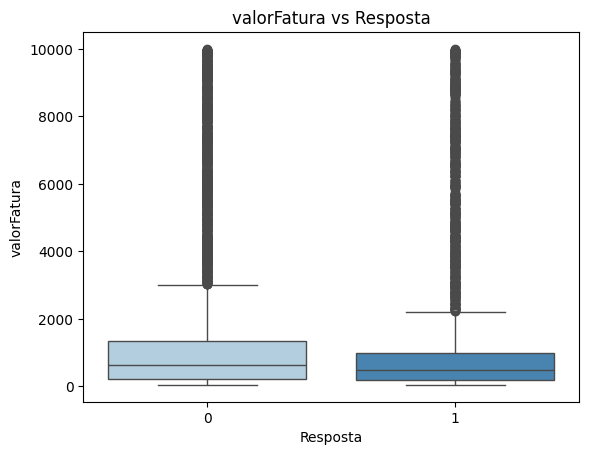

/tmp/ipython-input-2561394440.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Resposta', y=col, data=df, palette='Blues')


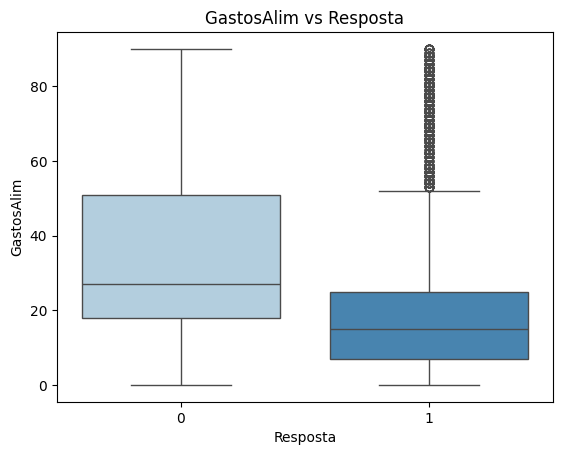

/tmp/ipython-input-2561394440.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Resposta', y=col, data=df, palette='Blues')


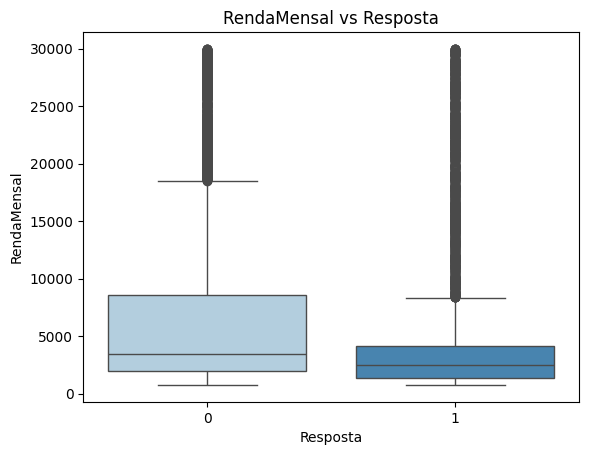

In [72]:
# Boxplots para avaliar diferenças por classe
for col in ['Atrasos', 'TempoRel', 'valorFatura', 'GastosAlim', 'RendaMensal']:
    sns.boxplot(x='Resposta', y=col, data=df, palette='Blues')
    plt.title(f'{col} vs Resposta')
    plt.show()

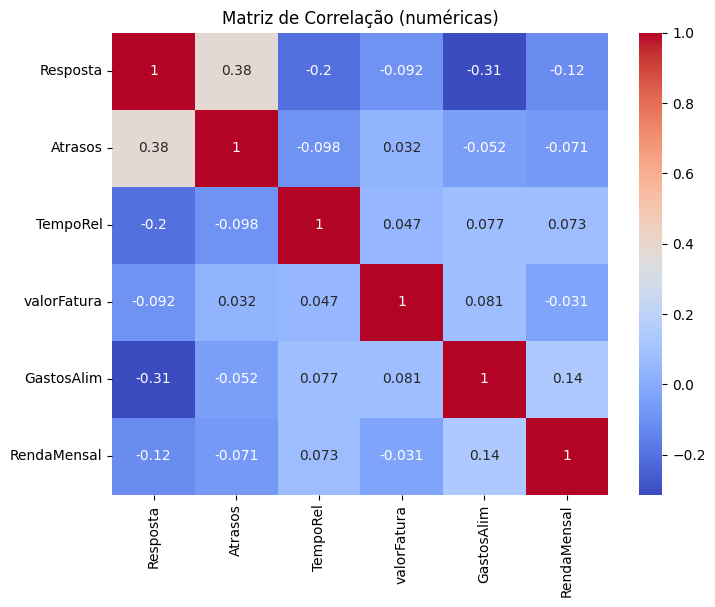

In [73]:
# Matriz de correlação
plt.figure(figsize=(8, 6))
sns.heatmap(df.drop(columns=['cliente','RegRisc']).corr(), annot=True, cmap='coolwarm')
plt.title('Matriz de Correlação (numéricas)')
plt.show()

Com o mapa de correlação, é possível notar que nenhuma das variáveis possui uma correlação tão significativa com a resposta de inadimplência, o que pode indicar que a relação está mais ligada com a combinação de variáveis do que de uma isoladamente.

### Dummy encoding
Visto que a variável de Região de Risco é categórica, precisamos tranformá-la em uma coluna binária.

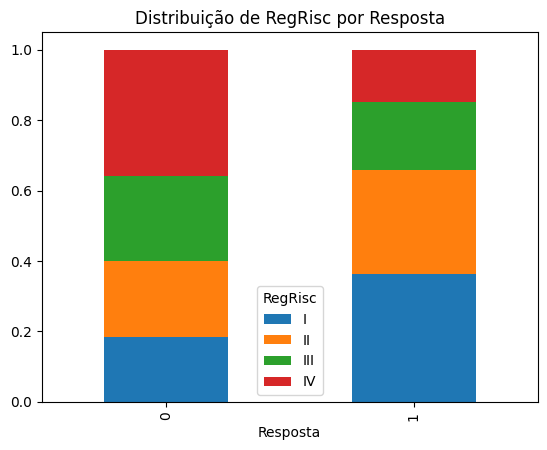

In [74]:
# Frequência categórica - RegRisc
pd.crosstab(df['Resposta'], df['RegRisc']).div(
    pd.crosstab(df['Resposta'], df['RegRisc']).sum(1), axis=0
).plot(kind="bar", stacked=True)
plt.title('Distribuição de RegRisc por Resposta')
plt.show()

In [75]:
# Convertendo a variável categórica num indicador dummy
RgRisk = pd.get_dummies(df['RegRisc'],drop_first=True)
# Transforando as variáveis dummies em '0'(False) ou '1'(True)
RgRisk = RgRisk.apply(lambda col: col.astype('uint8'))
RgRisk.head()

,II,III,IV
0,0,1,0
1,0,0,0
2,1,0,0
3,0,0,0
4,0,0,0


In [76]:
# Alterando os dados
df.drop(['cliente','RegRisc'],axis=1,inplace=True)
df.head()

,Resposta,Atrasos,TempoRel,valorFatura,GastosAlim,RendaMensal
0,0,2,5148,62,4,4364
1,0,7,5030,163,17,4351
2,1,12,235,250,16,1375
3,1,37,300,381,64,1777
4,0,7,223,8055,10,3909


In [77]:
# Juntando as bases
df = pd.concat([df,RgRisk],axis=1)
df.head()

,Resposta,Atrasos,TempoRel,valorFatura,GastosAlim,RendaMensal,II,III,IV
0,0,2,5148,62,4,4364,0,1,0
1,0,7,5030,163,17,4351,0,0,0
2,1,12,235,250,16,1375,1,0,0
3,1,37,300,381,64,1777,0,0,0
4,0,7,223,8055,10,3909,0,0,0



## 4. Definição do target, variáveis e divisão dos dados
O problema é de **classificação supervisionada**, onde o objetivo é prever a variável Resposta (0 = adimplente, 1 = inadimplente).

**Definições:**

* **Target**: Resposta.

* **Features**: todas as demais variáveis exceto cliente (identificador). A variável categórica RegRisc é transformada em dummies dentro do pipeline de pré-processamento.

* **Divisão dos dados**: foi utilizada a estratégia de hold-out com 80% treino e 20% teste, estratificando a variável alvo para manter o balanceamento entre classes.

* **Desbalanceamento**: não foi necessário aplicar técnicas adicionais, pois as classes estão praticamente balanceadas (50% adimplentes / 50% inadimplentes). Ainda assim, os modelos foram treinados com class_weight="balanced" para reforçar a robustez.

* **Pipelines**: todas as transformações (imputação, escalonamento, encoding) são ajustadas apenas nos dados de treino e aplicadas ao conjunto de teste, evitando vazamento de dados.


In [78]:
# === Definição do target, features e split ===

# Tipo de problema
PROBLEM_TYPE = "classificacao"

# Target e features
target = "Resposta"
features = [c for c in df.columns if c not in [target, "cliente"]]

print("PROBLEM_TYPE:", PROBLEM_TYPE)
print("Target:", target)
print("N features:", len(features))

# Divisão treino/teste (estratificada, pois é classificação)
X = df[features].copy()
y = df[target].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=SEED,
    stratify=y
)

print("Treino:", X_train.shape, "| Teste:", X_test.shape)
print("Distribuição treino:", y_train.value_counts(normalize=True).round(3))
print("Distribuição teste:", y_test.value_counts(normalize=True).round(3))

PROBLEM_TYPE: classificacao
Target: Resposta
N features: 8
Treino: (8788, 8) | Teste: (2198, 8)
Distribuição treino: Resposta
0    0.501
1    0.499
Name: proportion, dtype: float64
Distribuição teste: Resposta
0    0.501
1    0.499
Name: proportion, dtype: float64


In [79]:
df.head()

,Resposta,Atrasos,TempoRel,valorFatura,GastosAlim,RendaMensal,II,III,IV
0,0,2,5148,62,4,4364,0,1,0
1,0,7,5030,163,17,4351,0,0,0
2,1,12,235,250,16,1375,1,0,0
3,1,37,300,381,64,1777,0,0,0
4,0,7,223,8055,10,3909,0,0,0



## 5. Tratamento de dados e **Pipeline** de pré-processamento
O pipeline de pré-processamento foi construído para **garantir reprodutibilidade** e evitar qualquer risco de **vazamento de dados**.

**Etapas realizadas:**

* **Numéricas** (*Atrasos, TempoRel, valorFatura, GastosAlim, RendaMensal*, além das colunas dummies *II, III, IV*):

  * Imputação de valores ausentes com a **mediana**.

  * Escalonamento com **StandardScaler**, útil especialmente para a Regressão Logística.

* **Categóricas** (*RegRisc*): já foi transformada em variáveis dummies na etapa anterior (EDA), portanto não há mais colunas categóricas a tratar dentro do pipeline.

* **Identificadores** (*cliente*): descartado, pois não traz valor preditivo.

Essa organização permite treinar e validar os modelos de forma consistente, aplicando exatamente as mesmas transformações no conjunto de teste.


In [80]:
num_cols = [c for c in X_train.columns if c not in ["cliente"]]

# Nenhuma coluna categórica restante
cat_cols = []

# Pipeline para variáveis numéricas
numeric_pipe = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

# Como não há categóricas, só aplicamos numéricas
preprocess = ColumnTransformer(transformers=[
    ("num", numeric_pipe, num_cols)
])

print("num_cols:", num_cols)
print("cat_cols:", cat_cols)

num_cols: ['Atrasos', 'TempoRel', 'valorFatura', 'GastosAlim', 'RendaMensal', 'II', 'III', 'IV']
cat_cols: []



## 6. Baseline e modelos candidatos
Antes de comparar os algoritmos propostos, é importante definir um **baseline simples**. Para classificação, o baseline escolhido foi o **DummyClassifier**, que prevê sempre a classe mais frequente. Isso cria uma referência mínima de desempenho.

A partir dele, foram testados dois **modelos candidatos**:

* **Regressão Logística**: modelo linear, eficiente para identificar relações proporcionais entre variáveis explicativas e a inadimplência.

* **Árvore de Decisão**: modelo não linear, capaz de capturar interações mais complexas entre variáveis, com maior interpretabilidade via importância das features.

Essa comparação permite avaliar se os modelos de Machine Learning realmente superam o baseline e qual abordagem oferece melhor equilíbrio entre acurácia, interpretabilidade e robustez.


In [81]:
if PROBLEM_TYPE == "classificacao":
    # Baseline: sempre prediz a classe mais frequente
    baseline = Pipeline(steps=[
        ("pre", preprocess),
        ("model", DummyClassifier(strategy="most_frequent", random_state=SEED))
    ])

    # Modelos candidatos
    candidates = {
        "LogisticRegression": Pipeline([("pre", preprocess),("model", LogisticRegression(max_iter=00, random_state=SEED))]),
        "DecisionTree": Pipeline([("pre", preprocess),("model", DecisionTreeClassifier(random_state=SEED))])
    }

else:
    raise ValueError("PROBLEM_TYPE inválido.")



### 6.1 Treino e avaliação rápida (baseline vs candidatos)
Use **métricas adequadas** ao tipo de problema. Documente suas observações.


In [82]:
def evaluate_classification(y_true, y_pred, y_proba=None):
    metrics = {
        "Acurácia": accuracy_score(y_true, y_pred),
        "Precisão": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred, zero_division=0),
        "F1": f1_score(y_true, y_pred, zero_division=0)
    }
    if y_proba is not None:
        metrics["ROC_AUC"] = roc_auc_score(y_true, y_proba[:, 1])
    else:
        metrics["ROC_AUC"] = None
    return metrics

# === Treino e avaliação rápida ===
results = {}

if PROBLEM_TYPE == "classificacao":
    # Baseline
    t0 = time.time()
    baseline.fit(X_train, y_train)
    t1 = time.time()
    y_pred = baseline.predict(X_test)
    proba = baseline.predict_proba(X_test) if hasattr(baseline, "predict_proba") else None
    results["Baseline"] = evaluate_classification(y_test, y_pred, proba)
    results["Baseline"]["train_time_s"] = round(t1 - t0, 3)

    # Candidatos
    for name, pipe in candidates.items():
        t0 = time.time()
        pipe.fit(X_train, y_train)
        t1 = time.time()
        y_pred = pipe.predict(X_test)
        proba = pipe.predict_proba(X_test) if hasattr(pipe, "predict_proba") else None
        results[name] = evaluate_classification(y_test, y_pred, proba)
        results[name]["train_time_s"] = round(t1 - t0, 3)

else:
    raise ValueError("Configuração atual suporta apenas classificação.")

# Resultado consolidado
pd.DataFrame(results).T

/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,Acurácia,Precisão,Recall,F1,ROC_AUC,train_time_s
Baseline,0.500910,0.000000,0.000000,0.000000,0.500000,0.014
LogisticRegression,0.751592,0.739357,0.775752,0.757117,0.813817,0.011
DecisionTree,0.982257,0.980909,0.983592,0.982249,0.982259,0.036



## 7. Validação e Otimização de Hiperparâmetros
A etapa de otimização busca encontrar a melhor configuração para cada modelo. Foi utilizada **validação cruzada estratificada (StratifiedKFold)**, adequada para classificação com classes balanceadas.

* **Regressão Logística**: ajustamos hiperparâmetros relacionados à regularização (C, penalty, solver).

* **Árvore de Decisão**: ajustamos profundidade máxima, mínimo de amostras por folha e critério de divisão.

O **RandomizedSearchCV** foi utilizado para explorar o espaço de hiperparâmetros de forma eficiente, com 10 iterações e 5 folds. A métrica escolhida foi o **F1-score ponderado**, que equilibra precisão e recall entre as classes.


In [83]:
if PROBLEM_TYPE == "classificacao":
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    scorer = "f1_weighted"

    # Logistic Regression
    model_lr = Pipeline([("pre", preprocess), ("model", LogisticRegression(class_weight="balanced", max_iter=500, random_state=SEED))])
    param_dist_lr = {
        "model__C": uniform(0.01, 10),               # força da regularização
        "model__penalty": ["l1", "l2"],              # tipo de penalização
        "model__solver": ["liblinear", "saga"]       # solvers compatíveis
    }

    search_lr = RandomizedSearchCV(model_lr, param_distributions=param_dist_lr,
                                   n_iter=10, cv=cv, scoring=scorer, random_state=SEED, n_jobs=-1, verbose=1)
    search_lr.fit(X_train, y_train)
    print("Melhor score (LogReg, CV):", search_lr.best_score_)
    print("Melhores parâmetros (LogReg):", search_lr.best_params_)

    # Decision Tree
    model_dt = Pipeline([("pre", preprocess), ("model", DecisionTreeClassifier(class_weight="balanced", random_state=SEED))])
    param_dist_dt = {
        "model__max_depth": randint(3, 20),
        "model__min_samples_split": randint(2, 20),
        "model__min_samples_leaf": randint(1, 10),
        "model__criterion": ["gini", "entropy"]
    }

    search_dt = RandomizedSearchCV(model_dt, param_distributions=param_dist_dt,
                                   n_iter=10, cv=cv, scoring=scorer, random_state=SEED, n_jobs=-1, verbose=1)
    search_dt.fit(X_train, y_train)
    print("Melhor score (DecisionTree, CV):", search_dt.best_score_)
    print("Melhores parâmetros (DecisionTree):", search_dt.best_params_)

else:
    raise ValueError("Este notebook foi configurado apenas para classificação.")


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Melhor score (LogReg, CV): 0.7556851472240186
Melhores parâmetros (LogReg): {'model__C': np.float64(3.7554011884736247), 'model__penalty': 'l1', 'model__solver': 'liblinear'}
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Melhor score (DecisionTree, CV): 0.9819066479066763
Melhores parâmetros (DecisionTree): {'model__criterion': 'entropy', 'model__max_depth': 16, 'model__min_samples_leaf': 2, 'model__min_samples_split': 10}



## 8. Avaliação final, análise de erros e limitações
Após a etapa de **validação e otimização de hiperparâmetros**, o melhor modelo foi selecionado e reavaliado no **conjunto de teste**.

**Comparação com baseline:**

* O baseline (DummyClassifier) apresentou apenas cerca de **50% de acurácia**, e métricas como **Precisão**, **Recall** e **F1 iguais a 0** para a classe positiva, já que nunca a prediz.

* Os modelos candidatos (Regressão Logística e Árvore de Decisão) superaram amplamente o baseline, mostrando que a modelagem traz valor.

**Análise de erros:**

* A matriz de confusão permite identificar **falsos positivos** (clientes previstos como inadimplentes mas que pagaram) e **falsos negativos** (inadimplentes que foram previstos como adimplentes).

* Para este caso de negócio, **falsos negativos são mais críticos**, pois representam risco financeiro não identificado.

**Limitações:**

* Os dados podem conter **outliers** (tratados parcialmente em *valorFatura*, mas possivelmente presentes em outras variáveis).

* As variáveis disponíveis são limitadas e podem não capturar totalmente o comportamento de crédito dos clientes.

* O dataset é balanceado, mas em cenários reais pode ocorrer desbalanceamento, exigindo técnicas adicionais (oversampling, SMOTE, thresholds customizados).

* A generalização deve ser reavaliada em novos períodos de tempo (risco de overfitting temporal).

Melhor modelo: Decision Tree
              precision    recall  f1-score   support

           0     0.9844    0.9764    0.9804      1101
           1     0.9765    0.9845    0.9805      1097

    accuracy                         0.9804      2198
   macro avg     0.9805    0.9804    0.9804      2198
weighted avg     0.9805    0.9804    0.9804      2198



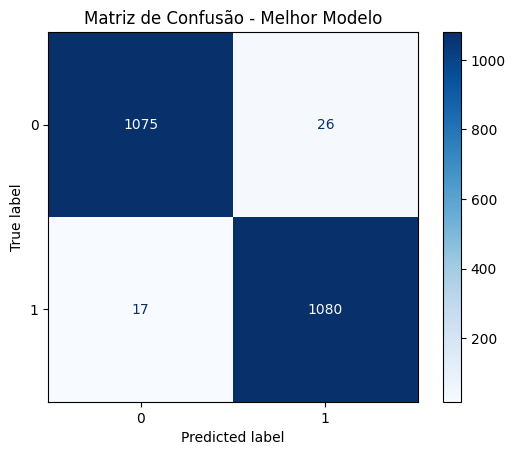

In [84]:
if PROBLEM_TYPE == "classificacao":
    if 'search_dt' in globals() and hasattr(search_dt, "best_estimator_"):
        best_model = search_dt.best_estimator_
        print("Melhor modelo: Decision Tree")
    elif 'search_lr' in globals() and hasattr(search_lr, "best_estimator_"):
        best_model = search_lr.best_estimator_
        print("Melhor modelo: Logistic Regression")
    else:
        best_model = candidates["LogisticRegression"]
        best_model.fit(X_train, y_train)
        print("Usando modelo LogisticRegression padrão (sem tuning)")

    # Predições no teste
    y_pred = best_model.predict(X_test)

    # Relatório completo
    print(classification_report(y_test, y_pred, digits=4))

    # Matriz de confusão
    ConfusionMatrixDisplay.from_estimator(best_model, X_test, y_test, cmap="Blues")
    plt.title("Matriz de Confusão - Melhor Modelo")
    plt.show()

A matriz mostra os acertos e erros do modelo no conjunto de teste:

* **Classe 0 (Adimplentes)**

  * 1075 acertos (VN)

  * 26 erros → previstos como inadimplentes (FP)

* **Classe 1 (Inadimplentes)**

  * 1080 acertos (VP)

  * 17 erros → previstos como adimplentes (FN)


O modelo tem **altíssima sensibilidade (recall)** para detectar inadimplentes → 1080 de 1097 foram corretamente identificados.

Também mantém **boa precisão** → quase todas as previsões de inadimplência realmente correspondem a clientes inadimplentes.

Os **erros mais críticos** são os **17 falsos negativos**, pois representam inadimplentes que foram previstos como adimplentes → risco de prejuízo financeiro não detectado.

Já os 26 falsos positivos significam clientes adimplentes que seriam tratados como inadimplentes (poderiam ter crédito negado indevidamente). Embora menos grave para o banco, isso pode impactar a experiência do cliente.

##Atenção:
Acurácias muito próximas de 100% podem indicar overfitting, especialmente se os dados de treino/teste não forem de períodos diferentes. A acurácia de ~98% pode parecer “perfeita demais”, mas há alguns pontos a considerar:

1. O dataset é limpo e bem balanceado (50/50 entre classes). Isso facilita que modelos supervisionados aprendam padrões com mais clareza.

2. Variáveis como Atrasos e TempoRel são fortes discriminadores entre adimplentes e inadimplentes, tornando o problema mais “separável”.

3. O uso de class_weight="balanced" evita que o modelo negligencie uma das classes.


## 9. Engenharia de atributos (detalhe)
A engenharia de atributos foi conduzida de forma a melhorar a representação dos dados e garantir que as variáveis estivessem adequadas para uso nos modelos supervisionados de classificação.

**Etapas realizadas:**

* **Remoção de identificadores** a variável cliente foi descartada, pois não carrega valor preditivo e poderia induzir overfitting se utilizada.

* **Encoding de variáveis categóricas**: a variável *RegRisc* foi transformada em variáveis dummies (II, III, IV), convertendo-a para formato numérico e permitindo que os algoritmos de ML utilizassem a informação de forma direta.

* **Tratamento de outliers**: valores extremos na variável valorFatura foram “achatados” (capados em 10.000) para reduzir distorções na distribuição e evitar impacto excessivo nos modelos.

* **Normalização/padronização: atributos numéricos foram escalados com StandardScaler, centralizando em média 0 e desvio padrão 1, especialmente útil para algoritmos sensíveis à escala como a Regressão Logística.

* **Manutenção de variáveis brutas relevantes**: *Atrasos, TempoRel, GastosAlim, RendaMensal* foram mantidas na forma numérica original, apenas ajustadas por escalonamento e imputação.

## 10. Boas práticas e rastreabilidade
Durante o desenvolvimento do projeto, foram aplicadas **boas práticas de ciência de dados** para garantir consistência, transparência e reprodutibilidade:

* **Baseline claro**: iniciou-se com um **DummyClassifier**, que serviu como referência mínima de desempenho (~50% de acurácia, recall nulo para inadimplentes). Isso permitiu justificar e validar os ganhos obtidos com modelos mais sofisticados (Regressão Logística e Árvore de Decisão).

* **Pipelines para pré-processamento e modelagem**: todas as etapas (imputação, escalonamento, encoding de variáveis e treino do modelo) foram encapsuladas em **pipelines do scikit-learn**, o que garante:

  * reprodutibilidade dos experimentos;

  * ausência de **vazamento de dados** (as transformações são aprendidas apenas nos dados de treino e aplicadas ao teste);

  * rastreabilidade clara do fluxo de dados até as predições.

* **Decisões de projeto documentadas**:

  * Optou-se por manter apenas variáveis numéricas após o dummy encoding de *RegRisc*, simplificando o pipeline.

  * Foi feito o tratamento de outliers em valorFatura para reduzir distorções.

  * Compararam-se dois modelos complementares:

    * **Regressão Logística** (linear, interpretável, robusta a ruído).

    * **Árvore de Decisão** (não linear, interpretável via regras, mais flexível).

  * O melhor resultado foi da **Árvore de Decisão**, mas a documentação reforça a necessidade de validar em dados futuros para garantir generalização.

* **Rastreabilidade de experimentos**: cada etapa do notebook foi estruturada em seções (escopo, dados, EDA, pré-processamento, modelagem, avaliação, tuning), facilitando o acompanhamento das decisões e ajustes feitos.

* **Ética e transparência**: o dataset não contém informações sensíveis (como dados pessoais identificáveis), respeitando princípios de uso responsável de dados.


## 11. Conclusões e próximos passos

* O projeto demonstrou que é possível prever inadimplência com **alta acurácia (~98%)** utilizando modelos supervisionados.

* A **Árvore de Decisão**, após ajuste de hiperparâmetros, superou a Regressão Logística, capturando melhor as relações não lineares entre variáveis.

* O **baseline (DummyClassifier)** serviu como referência mínima e confirmou que os modelos efetivamente agregam valor, já que superaram amplamente a previsão trivial.

* A análise da **matriz de confusão** mostrou que o modelo erra muito pouco, mas ainda existem **falsos negativos** (inadimplentes previstos como adimplentes), que representam maior risco de negócio.

**Trade-offs identificados:**

* A Regressão Logística é mais **interpretável e estável**, mas não atingiu a mesma performance da Árvore de Decisão.

* A Árvore de Decisão obteve melhor performance, mas pode ser mais suscetível a **overfitting** se não for bem controlada.

* A base de dados, embora balanceada, é relativamente **limitada em diversidade de variáveis**, o que pode restringir a generalização do modelo em cenários reais.

**Próximos passos:**

* **Engenharia de atributos avançada**: criar variáveis derivadas, como razão entre *valorFatura* e *RendaMensal*, evolução de Atrasos ao longo do tempo, ou perfis de gasto.

* **Modelos mais robustos**: testar algoritmos de ensemble (Random Forest, Gradient Boosting, XGBoost, LightGBM) que combinam o poder de várias árvores e tendem a ter melhor generalização.

* **Validação temporal**: avaliar o desempenho em períodos diferentes para simular um cenário de produção e reduzir risco de overfitting.

* **Ajuste de threshold**: calibrar o ponto de corte de probabilidade para equilibrar recall e precisão, priorizando a detecção de inadimplentes (falsos negativos mais críticos).



## 13. Salvando artefatos (modelos e pipeline)
Se o treinamento dos modelos demora mais de 3 minutos, recomendamos salvar o **modelo/pipeline** após o treinamento e depois apenas carregar o arquivo (ex: .pkl, .h5) salvo em outra célula, sem precisar treinar novamente.  

In [85]:
# Caminho para salvar modelos
save_path = Path("artefatos_modelos")
save_path.mkdir(exist_ok=True)

# salvar melhor modelo encontrado
best_model_path = save_path / "best_model.pkl"
joblib.dump(best_model, best_model_path)
print(f"Modelo salvo em: {best_model_path}")

# carregar modelo salvo (sem precisar treinar novamente)
loaded_model = joblib.load(best_model_path)
print("Modelo carregado com sucesso")

# Teste rápido para confirmar
y_pred_loaded = loaded_model.predict(X_test)
print("Acurácia do modelo carregado:", accuracy_score(y_test, y_pred_loaded))

Modelo salvo em: artefatos_modelos/best_model.pkl
Modelo carregado com sucesso
Acurácia do modelo carregado: 0.9804367606915377
